In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd '/content/gdrive/My Drive/Gdrive'

/content/gdrive/My Drive/Gdrive


In [3]:
ls

bottleneck_fc_model.h5  test/  train/  val/


In [4]:
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential 
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense  
from keras import applications  
from keras.utils.np_utils import to_categorical  
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import math  
import datetime
import time
from keras.layers import LeakyReLU
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import os
import tensorflow as tf

print('Tensorflow_VER= V',tf.version.VERSION)
print(confusion_matrix)

Tensorflow_VER= V 2.3.0
<function confusion_matrix at 0x7f02da17ff28>


In [5]:
#Feature Extraction cuy
img_width, img_height = 224, 224  

train_data_dir = '/content/gdrive/My Drive/Gdrive/train/'  
test_data_dir = '/content/gdrive/My Drive/Gdrive/test/'
validation_data_dir = '/content/gdrive/My Drive/Gdrive/val/'


top_model_weights_path = 'bottleneck_fc_model_vgg19.h5' 


#TUNING SEBAGIAN DISINI
batch_size = 8
lr=1e-4
opt='rmsprop'
epochs = 100 
  

vgg19 = applications.VGG19(include_top=False, weights='imagenet') 
vgg19.summary() #Arsitekturnya Wan

datagen = ImageDataGenerator(rescale=1. / 255)  
train_datagen = ImageDataGenerator(#rescale=1. / 255) 
        rescale=1. / 255,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)    
#

#Pre train Training
start = datetime.datetime.now()
   
train_generator = train_datagen.flow_from_directory(  
      train_data_dir,  
      target_size=(img_width, img_height),  
      batch_size=batch_size,  
      class_mode=None,  
      shuffle=False)  
   
nb_train_samples = len(train_generator.filenames)  
num_classes = len(train_generator.class_indices)  
   
predict_size_train = int(math.ceil(nb_train_samples / batch_size))  
   
bottleneck_features_train = vgg19.predict_generator(train_generator, predict_size_train)  
   
np.save('/content/gdrive/My Drive/Gdrive/bottleneck_features_train.npy', bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

#Pre-train Validation cuy
start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
      validation_data_dir,  
      target_size=(img_width, img_height),  
      batch_size=batch_size,  
      class_mode=None,  
      shuffle=False)  
   
nb_validation_samples = len(generator.filenames)  
num_classes = len(generator.class_indices)  

predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bottleneck_features_validation = vgg19.predict_generator(  
      generator, predict_size_validation)  
   
np.save('/content/gdrive/My Drive/Gdrive/bottleneck_features_validation.npy', bottleneck_features_validation) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

#Pre train Testing
start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
      test_data_dir,  
      target_size=(img_width, img_height),  
      batch_size=batch_size,  
      class_mode=None,  
      shuffle=False)  
   
nb_test_samples = len(generator.filenames)  
   
predict_size_test = int(math.ceil(nb_test_samples / batch_size))  
   
bottleneck_features_test = vgg19.predict_generator(  
      generator, predict_size_test)  
   
np.save('/content/gdrive/My Drive/Gdrive/bottleneck_features_test.npy', bottleneck_features_test) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

Found 74 images belonging to 3 classes.
Found 74 images belonging to 3 classes.

Epoch 00001: val_acc improved from -inf to 0.81081, saving model to /content/gdrive/My Drive/models/vgg19/best_model.h5

Epoch 00002: val_acc did not improve from 0.81081

Epoch 00003: val_acc did not improve from 0.81081

Epoch 00004: val_acc did not improve from 0.81081

Epoch 00005: val_acc did not improve from 0.81081

Epoch 00006: val_acc did not improve from 0.81081

Epoch 00007: val_acc did not improve from 0.81081

Epoch 00008: val_acc did not improve from 0.81081

Epoch 00009: val_acc did not improve from 0.81081

Epoch 00010: val_acc improved from 0.81081 to 0.83784, saving model to /content/gdrive/My Drive/models/vgg19/best_model.h5

Epoch 00011: val_acc did not improve from 0.83784

Epoch 00012: val_acc did not improve from 0.83784

Epoch 00013: val_acc did not improve from 0.83784

Epoch 00014: val_acc did not improve from 0.83784

Epoch 00015: val_acc did not improve from 0.83784

Epoch 00016

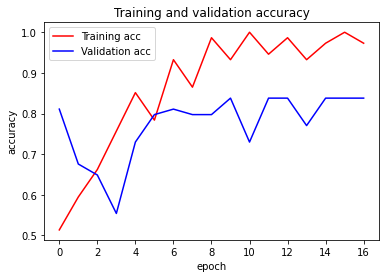

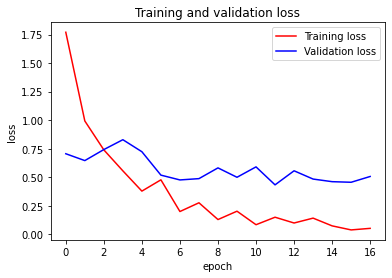

In [12]:
#TRAINING dan Testing
from sklearn.metrics import confusion_matrix
#TRAINING
#hasil= []
#vgg19 = applications.vgg19(include_top=False, weights='imagenet') 
def read_image(file_path):
    print("[INFO] loading and preprocessing image...")  
    image = load_img(file_path, target_size=(224, 224))  
    image = img_to_array(image)  
    image = np.expand_dims(image, axis=0)
    image /= 255.  
    return image

#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("confusion matrix yang dinormalisasi \n\n\n")
    else:
        print('Confusion matrix tanpa normalisasi \n\n\n')
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


img_width, img_height = 224, 224  
top_model_weights_path = 'bottleneck_fc_model.h5' 

datagen = ImageDataGenerator(rescale=1. / 255) 
 
#training data
generator_top = datagen.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
train_data = np.load('/content/gdrive/My Drive/Gdrive/bottleneck_features_train.npy')  
   
train_labels = generator_top.classes  
   
train_labels = to_categorical(train_labels, num_classes=num_classes) 

#testing data
generator_top = datagen.flow_from_directory(  
         test_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
   
test_data = np.load('/content/gdrive/My Drive/Gdrive/bottleneck_features_test.npy')  
   

test_labels = generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)

#Lanjut training 
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
#model.add(Dense(100, activation=LeakyReLU(alpha=0.3)))
model.add(Dense(100))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.5))  
#model.add(Dense(50, activation=LeakyReLU(alpha=0.3)))
model.add(Dense(50))
model.add(LeakyReLU(alpha=0.3))  
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))  

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=lr),
              metrics=['acc'])  


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('/content/gdrive/My Drive/models/vgg19/best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# history = model.fit(train_data, train_labels,  
#       epochs=20,
#       batch_size=batch_size,  
#       validation_data=(test_data, test_labels))


history = model.fit(train_data, train_labels,  
      epochs=100,
      batch_size=batch_size,  
      validation_data=(test_data, test_labels),
      verbose=0,
      callbacks=[es, mc])    

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 test_data, test_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

#Model summary
model.summary()

#Graphing our training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plotacc = plt.figure(1)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plotacc.show()
plt.savefig("/content/gdrive/My Drive/gambar/vgg19/train/Acc_vgg19_{}Batch_{}E_Opt={}_lr={}.jpg".format(batch_size, len(acc),opt,lr))



plotloss = plt.figure(2)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plotloss.show()
plt.savefig("/content/gdrive/My Drive/gambar/vgg19/train/Loss_vgg19_{}Batch_{}E_Opt={}_lr={}.jpg".format(batch_size, len(acc),opt,lr))

Evaluasi=model.evaluate(test_data, test_labels)
print(Evaluasi)


print('test data', test_data)
preds = np.round(model.predict(test_data),0) 
score = model.predict(test_data)
#to fit them into classification metrics and confusion metrics, some additional modificaitions are required
print('rounded test_labels', preds)
#Model di save 
model.save('/content/gdrive/My Drive/models/vgg19/model_{}E.h5'.format(len(acc)))

view = ['Halal','Haram','meragukan']
classification_metrics = metrics.classification_report(test_labels, preds, target_names=view )
print(classification_metrics)

#Since our data is in dummy format we put the numpy array into a dataframe and call idxmax axis=1 to return the column
# label of the maximum value thus creating a categorical variable
#Basically, flipping a dummy variable back to it's categorical variable
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)
confusion_matrix= confusion_matrix(categorical_test_labels, categorical_preds)


Confusion matrix tanpa normalisasi 



confusion matrix yang dinormalisasi 





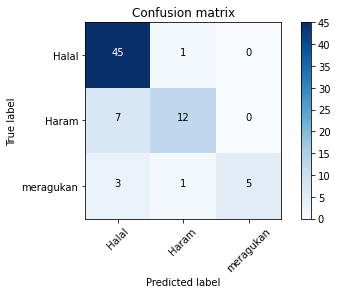

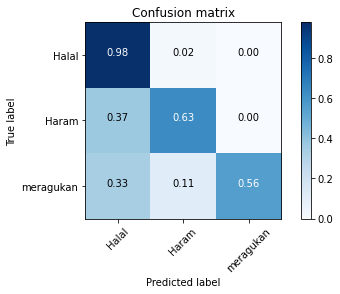

In [13]:
plotcmnn = plt.figure(3)    
plot_confusion_matrix(confusion_matrix, ['Halal','Haram','meragukan'])  
plt.savefig("/content/gdrive/My Drive/gambar/vgg19/train/CMNN_vgg19_{}Batch_{}E_Opt={}_lr={}.jpg".format(batch_size, len(acc),opt,lr))

plotcmn = plt.figure(4) 
plot_confusion_matrix(confusion_matrix, ['Halal','Haram','meragukan'],normalize=True)
plt.savefig("/content/gdrive/My Drive/gambar/vgg19/train/CMN_vgg19_{}Batch_{}E_Opt={}_lr={}.jpg".format(batch_size, len(acc),opt,lr))

In [15]:
#TESTING
from sklearn.metrics import confusion_matrix
#vgg19 = applications.vgg19(include_top=False, weights='imagenet')
 
def read_image(file_path):
    print("[INFO] loading and preprocessing image...")  
    image = load_img(file_path, target_size=(224, 224))  
    image = img_to_array(image)  
    image = np.expand_dims(image, axis=0)
    image /= 255.  
    return image

def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("confusion matrix yang dinormalisasi \n\n\n")
    else:
        print('Confusion matrix tanpa normalisasi \n\n\n')
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def predict(path):
    view = ['Halal','Haram','meragukan']
    images = read_image(path)
#    time.sleep(.5)
    bt_prediction = vgg19.predict(images)  
    preds = model.predict_proba(bt_prediction)
#    for idx, view, x in zip(range(0,6), view , preds[0]):
#        print("ID: {}, Label: {} {}%".format(idx, view, round(x*100,2) ))
#    print('Final Decision:')
#    time.sleep(.5)
#    for x in range(3):
#        print('.'*(x+1))
#        time.sleep(.2)
    class_predicted = model.predict_classes(bt_prediction)
    class_dictionary = generator_top.class_indices  
    inv_map = {v: k for k, v in class_dictionary.items()}  
#    print("ID: {}, Label: {}".format(class_predicted[0], inv_map[class_predicted[0]]))  
    return load_img(path)

img_width, img_height = 224, 224  
top_model_weights_path = 'bottleneck_fc_model.h5' 

  
datagen = ImageDataGenerator(rescale=1. / 255) 

#training data
generator_top = datagen.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
train_data = np.load('/content/gdrive/My Drive/Gdrive/bottleneck_features_train.npy')  

train_labels = generator_top.classes  
   
train_labels = to_categorical(train_labels, num_classes=num_classes) 

#validation data
generator_top = datagen.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('/content/gdrive/My Drive/Gdrive/bottleneck_features_validation.npy')  
   

validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

#testing data
generator_top = datagen.flow_from_directory(  
         test_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
   
test_data = np.load('/content/gdrive/My Drive/Gdrive/bottleneck_features_test.npy')  
   

test_labels = generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)



 
#model = tf.keras.models.load_model('/content/gdrive/My Drive/CODE/models/vgg19/best_model.h5')
model = tf.keras.models.load_model('/content/gdrive/My Drive/models/vgg19/best_model.h5')
model.summary()

model.evaluate(validation_data, validation_labels)

print('validation data', validation_data)
preds = np.round(model.predict(validation_data),0) 
score = model.predict(validation_data)
#to fit them into classification metrics and confusion metrics, some additional modificaitions are required
print('rounded validation_labels', preds)

view = ['Halal','Haram','meragukan']
classification_metrics = metrics.classification_report(validation_labels, preds, target_names=view )
print(classification_metrics)

categorical_validation_labels = pd.DataFrame(validation_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)
confusion_matrix= confusion_matrix(categorical_validation_labels, categorical_preds)

Found 74 images belonging to 3 classes.
Found 74 images belonging to 3 classes.
Found 74 images belonging to 3 classes.
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 100)               2508900   
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 100)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 50)                5050      
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 50)                0         


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix tanpa normalisasi 





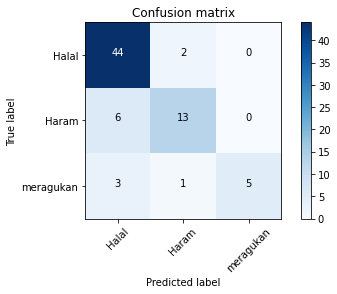

In [16]:
plotcmnn = plt.figure(5)    
plot_confusion_matrix(confusion_matrix, ['Halal','Haram','meragukan'])
plt.savefig("/content/gdrive/My Drive/gambar/vgg19/test/CMNN_vgg19_{}Batch_{}E_Opt={}_lr={}.jpg".format(batch_size, len(acc),opt,lr))

# plotcmn = plt.figure(6) 
# plot_confusion_matrix(confusion_matrix, ['FCV','LVOT' , 'RVOT' ,'TVT' ],normalize=True)
# # plt.savefig('gambar/vgg19/test/20e/CMN_vgg19_20E')
# plt.savefig('gambar/vgg19/test/50e/CMN_vgg19_50E')